In [167]:
from statsbombpy import sb
import json

In [140]:
comps = sb.competitions()
seasons_num_games = pd.Series()
for idx, row in comps[comps.competition_gender == 'male'][['competition_id','season_id','season_name','competition_name']].iterrows():
    comp_id = row['competition_id']
    season_id = row['season_id']
    season_name = row['season_name']
    competition_name = row['competition_name']
    matches = sb.matches(comp_id,season_id)
    if len(matches) > 300:
        seasons_num_games[season_name+" "+competition_name] = len(matches)
        print(comp_id, season_id, season_name, competition_name)


9 27 2015/2016 1. Bundesliga
11 27 2015/2016 La Liga
7 27 2015/2016 Ligue 1
2 27 2015/2016 Premier League
12 27 2015/2016 Serie A


In [214]:
seasons_num_games.sort_values(ascending=False).head(5).

1823

In [159]:
print("Amount of Games: ",sb.matches(2,27).shape[0])
matches = sb.matches(2,27)
match = matches.iloc[1]
home_team = match.home_team
away_team = match.away_team
match_id = match.match_id

Amount of Games:  380


In [160]:
events =  sb.events(match_id).sort_values(by=["period","timestamp"],ascending=[True,True])

In [161]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
import pandas as pd

# Preprocessing

In [162]:
def preprocessing(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]
    return ordered_events

In [163]:
ordered_events = preprocessing(events)

In [9]:
def preprocessing_for_model_input(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]
    ordered_events = ordered_events[ordered_events["possession_team"] == ordered_events["team"]]


    # shots = ordered_events[ordered_events.type == "Shot"]
    # # Find possessions that resulted in goals
    # # Create a series of 1s for possessions that resulted in goals, 0s otherwise
    # goals = pd.Series(1, index=shots[shots.shot_outcome == "Goal"]["possession"].unique())
    # goals = pd.DataFrame({"possession": goals.index, "goal_in_possession": goals.values})

    # # Merge goal information with events, filling non-goal possessions with 0
    # ordered_events = ordered_events.merge(goals, on="possession", how="left")
    # ordered_events["goal_in_possession"] = ordered_events["goal_in_possession"].fillna(0)

    potential_missing = ['pass_cross','pass_cut_back','pass_switch','pass_through_ball']
    for col in potential_missing:
        if col not in ordered_events.columns:
            ordered_events[col] = np.nan
    df = ordered_events[['team','possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height']]
    df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
    df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
    df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
    df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
    df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
    # One-hot encode the type column
    type_dummies = pd.get_dummies(df['type'], prefix='pass').rename(columns=lambda x: x.replace(' ', '_').lower()).astype(int)
    df = pd.concat([df, type_dummies], axis=1)
    for i in range(1, 5):
            # Previous pass outcomes
        df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

        # Previous pass angles
        df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
        
        # Previous pass lengths  
        df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)

        # Previous pass types
        df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
        df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
        df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
        df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
        df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)

        
        # Previous pass start coordinates
        df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
        df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
        
        # Previous pass end coordinates
        df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
        df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

        df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
        df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

        df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
        df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
            
        # Previous pass type dummies
        for col in type_dummies.columns:
            df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
    # Find last non-null pass end coordinates by checking each previous pass in sequence
    last_pass_x2 = df['prev_pass4_x2'].fillna(
        df['prev_pass3_x2'].fillna(
            df['prev_pass2_x2'].fillna(
                df['prev_pass1_x2'].fillna(
                    df['x2']
                )
            )
        )
    )
    last_pass_y2 = df['prev_pass4_y2'].fillna(
        df['prev_pass3_y2'].fillna(
            df['prev_pass2_y2'].fillna(
                df['prev_pass1_y2'].fillna(
                    df['y2']
                )
            )
        )
    )
    
    # Calculate direct length from current pass start to last pass end
    df['num_passes'] = 1+df['prev_pass1_outcome'].notna().astype(int) + df['prev_pass2_outcome'].notna().astype(int) + df['prev_pass3_outcome'].notna().astype(int) + df['prev_pass4_outcome'].notna().astype(int)
    df['direct_length'] = np.sqrt((last_pass_x2-df['x1']).pow(2) + (last_pass_y2-df['y1']).pow(2))
    df['total_length'] = df['pass_length'] + df['prev_pass1_length'].fillna(0) + df['prev_pass2_length'].fillna(0) + df['prev_pass3_length'].fillna(0) + df['prev_pass4_length'].fillna(0)
    df['directness'] = np.where(df['num_passes'] == 1, np.nan, df['direct_length']/df['total_length'])
    df['direct_angle'] = np.where(df['num_passes'] == 1, np.nan, np.arctan2(last_pass_y2 - df['y1'], last_pass_x2 - df['x1']))
    df['all_successful'] = ((df['outcome'] == 1) & (df['prev_pass1_outcome'].fillna(1) == 1) & (df['prev_pass2_outcome'].fillna(1) == 1) & (df['prev_pass3_outcome'].fillna(1) == 1) & (df['prev_pass4_outcome'].fillna(1) == 1)).astype(int)
    cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type']
    df = df.drop(cols_to_drop,axis=1)
    return df, df.drop(['team','possession'],axis=1)

In [ ]:
def processed_to_model(processed_events):
    processed_events = processed_events[ordered_events["possession_team"] == ordered_events["team"]]

    
    shots = processed_events[processed_events.type == "Shot"]
    # Find possessions that resulted in goals
    # Create a series of 1s for possessions that resulted in goals, 0s otherwise
    goals = pd.Series(1, index=shots[shots.shot_outcome == "Goal"]["possession"].unique())
    goals = pd.DataFrame({"possession": goals.index, "goal_in_possession": goals.values})

    # Merge goal information with events, filling non-goal possessions with 0
    processed_events = processed_events.merge(goals, on="possession", how="left")
    processed_events["goal_in_possession"] = processed_events["goal_in_possession"].fillna(0)
    potential_missing = ['pass_cross','pass_cut_back','pass_switch','pass_through_ball']
    for col in potential_missing:
        if col not in processed_events.columns:
            processed_events[col] = np.nan

    df = processed_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height']]
    df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
    df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
    df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
    df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
    df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
    # One-hot encode the type column
    df['pass_pass'] = (df['type'] == 'Pass').astype(int)
    df['pass_corner'] = (df['type'] == 'Corner').astype(int)
    df['pass_free_kick'] = (df['type'] == 'Free Kick').astype(int)
    df['pass_goal_kick'] = (df['type'] == 'Goal Kick').astype(int)
    df['pass_throw_in'] = (df['type'] == 'Throw-in').astype(int)
    
    pass_type_columns = ['pass_pass', 'pass_corner', 'pass_free_kick', 'pass_goal_kick', 'pass_throw_in']
    
    for i in range(1, 5):
        # Previous pass outcomes
        df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

        # Previous pass angles
        df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
        
        # Previous pass lengths  
        df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)

        # Previous pass types
        df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
        df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
        df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
        df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
        df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)

        
        # Previous pass start coordinates
        df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
        df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
        
        # Previous pass end coordinates
        df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
        df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

        df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
        df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

        df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
        df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
            
            # Previous pass type dummies
        for col in pass_type_columns:
            df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
    # Find last non-null pass end coordinates by checking each previous pass in sequence
    last_pass_x2 = df['prev_pass4_x2'].fillna(
        df['prev_pass3_x2'].fillna(
            df['prev_pass2_x2'].fillna(
                df['prev_pass1_x2'].fillna(
                    df['x2']
                )
            )
        )
    )
    last_pass_y2 = df['prev_pass4_y2'].fillna(
        df['prev_pass3_y2'].fillna(
            df['prev_pass2_y2'].fillna(
                df['prev_pass1_y2'].fillna(
                    df['y2']
                )
            )
        )
    )
    
    # Calculate direct length from current pass start to last pass end
    df['num_passes'] = 1+df['prev_pass1_outcome'].notna().astype(int) + df['prev_pass2_outcome'].notna().astype(int) + df['prev_pass3_outcome'].notna().astype(int) + df['prev_pass4_outcome'].notna().astype(int)
    df['direct_length'] = np.sqrt((last_pass_x2-df['x1']).pow(2) + (last_pass_y2-df['y1']).pow(2))
    df['total_length'] = df['pass_length'] + df['prev_pass1_length'].fillna(0) + df['prev_pass2_length'].fillna(0) + df['prev_pass3_length'].fillna(0) + df['prev_pass4_length'].fillna(0)
    df['directness'] = np.where(df['num_passes'] == 1, np.nan, df['direct_length']/df['total_length'])
    df['direct_angle'] = np.where(df['num_passes'] == 1, np.nan, np.arctan2(last_pass_y2 - df['y1'], last_pass_x2 - df['x1']))
    df['all_successful'] = ((df['outcome'] == 1) & (df['prev_pass1_outcome'].fillna(1) == 1) & (df['prev_pass2_outcome'].fillna(1) == 1) & (df['prev_pass3_outcome'].fillna(1) == 1) & (df['prev_pass4_outcome'].fillna(1) == 1)).astype(int)
    cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type','possession']
    df = df.drop(cols_to_drop,axis=1)
    return df
processed_to_model(preprocessing(events))

NameError: name 'events' is not defined

In [34]:
# Split events by team
away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

# Function to flip coordinates
def flip_coordinates(coords):
    if isinstance(coords, list):
        return [120 - coords[0], 80 - coords[1]]
    return coords

# Flip all coordinate columns for away team
coordinate_columns = ["location", "end_loc"]
for column in coordinate_columns:
    away_team_df[column] = away_team_df[column].apply(flip_coordinates)

# Combine home and away events
ordered_events = pd.concat([home_team_df, away_team_df])


In [ ]:
def preprocessing_for_possession_graphing(events,away_team,home_team):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

    away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
    home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

    # Function to flip coordinates
    def flip_coordinates(coords):
        if isinstance(coords, list):
            return [120 - coords[0], 80 - coords[1]]
        return coords

    # Flip all coordinate columns for away team
    coordinate_columns = ["location", "end_loc"]
    for column in coordinate_columns:
        away_team_df[column] = away_team_df[column].apply(flip_coordinates)

    # Combine home and away events
    ordered_events = pd.concat([home_team_df, away_team_df])
    return ordered_events

# Visualizing Passes

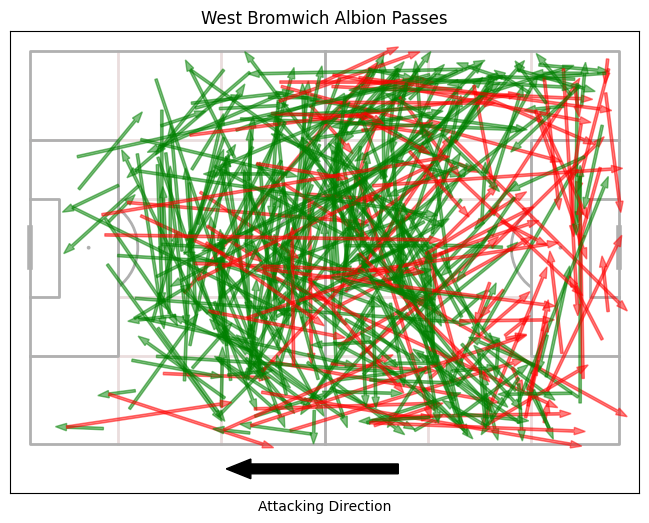

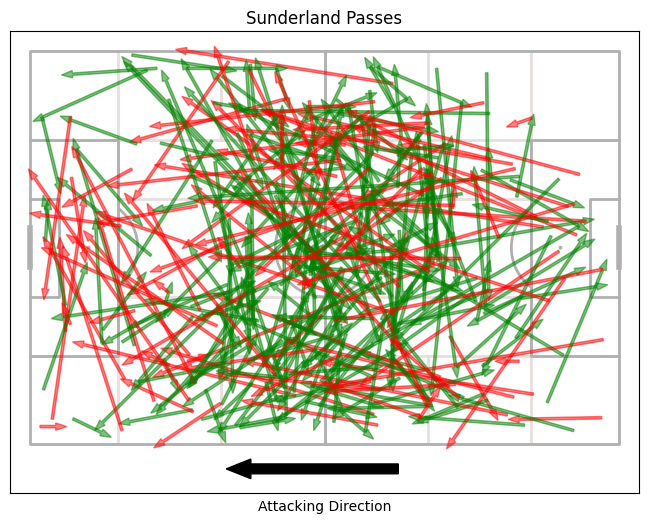

In [35]:
teams = [home_team,away_team]
for team in teams:
    pitch = Pitch(positional=True, axis=True,pad_bottom=10)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    passes = ordered_events[(ordered_events["type"]=="Pass") & (ordered_events["team"] == team)]
    for i in range(len(passes)):
        row = passes.iloc[i]
        x, y = row["location"]
        x_end, y_end = row["end_loc"]
        result = row["outcome"]
        color = 'g' if result else 'r'
        plt.arrow(x, y, x_end-x, y_end-y, color=color, alpha=0.5, width=0.5, ls='-')
    plt.title(f"{team} Passes")
    plt.xlabel("Attacking Direction")
    # Add attacking direction arrows using ax instead of plt
    if team == "AFC Bournemouth":
        ax.arrow(45, 85, 30, 0, head_width=4, head_length=5, fc='black', ec='black', width=2)
    else:
        ax.arrow(75, 85, -30, 0, head_width=4, head_length=5, fc='black', ec='black', width=2)
    plt.show()

# Visualizing Possessions

In [36]:
ordered_events[ordered_events["possession"]==7][["type","pass_outcome","pass_type","duel_outcome","team","possession_team"]]

,type,pass_outcome,pass_type,duel_outcome,team,possession_team
2873,Clearance,NaN,NaN,NaN,West Bromwich Albion,Sunderland
2874,Clearance,NaN,NaN,NaN,West Bromwich Albion,Sunderland
45,Throw-in,NaN,Throw-in,NaN,Sunderland,Sunderland
1735,Carry,NaN,NaN,NaN,Sunderland,Sunderland
46,Pass,NaN,NaN,NaN,Sunderland,Sunderland
47,Pass,NaN,NaN,NaN,Sunderland,Sunderland
2942,Miscontrol,NaN,NaN,NaN,Sunderland,Sunderland
1736,Carry,NaN,NaN,NaN,Sunderland,Sunderland
2585,Ball Recovery,NaN,NaN,NaN,Sunderland,Sunderland
48,Pass,Pass Offside,NaN,NaN,Sunderland,Sunderland


In [13]:
def plot_possession(ordered_events,home_team,away_team,possession):
    away_team_df = ordered_events[ordered_events["team"] == away_team].copy()
    home_team_df = ordered_events[ordered_events["team"] == home_team].copy()

    # Function to flip coordinates
    def flip_coordinates(coords):
        if isinstance(coords, list):
            return [120 - coords[0], 80 - coords[1]]
        return coords

    # Flip all coordinate columns for away team
    coordinate_columns = ["location", "end_loc"]
    for column in coordinate_columns:
        away_team_df[column] = away_team_df[column].apply(flip_coordinates)

    # Combine home and away events
    ordered_events = pd.concat([home_team_df, away_team_df])

    possession_events = ordered_events[ordered_events["possession"] == possession]
    team = possession_events["possession_team"].unique()[0]
    
    # Create pitch visualization
    pitch = Pitch(positional=True, axis=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)
    
    # Sort events by timestamp and calculate width increment
    possession_events = possession_events.sort_values(by=["timestamp"], ascending=True)
    min_width = .5
    max_width = 5
    width_increment = (max_width - min_width) / len(possession_events)
    
    # Get first and last event locations
    first_event = possession_events.iloc[0]
    last_event = possession_events.iloc[-1]
    start_x, start_y = first_event["location"]
    end_x, end_y = last_event["location"]
    
    # Plot each event
    j=0
    for i, event in possession_events.iterrows():
        x, y = event["location"]
        event_team = event["team"]
        width = min_width + j * width_increment
        marker_size = 4 + j * 2

        if event["type"] in ["Goal Kick","Corner", "Free Kick", "Throw-in"] and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'k'
            linestyle = (0, (4, 4, 4, 4)) if event["type"] == "Throw-in" else '-'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls=linestyle)
            
        elif event["type"] == "Pass" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            color = 'g' if event["outcome"] else 'r'
            if event_team != team:
                color = 'gray'
            plt.arrow(x, y, end_x-x, end_y-y, color=color, alpha=0.5, width=width, ls='-')
            
        elif event["type"] == "Shot":
            plt.plot(x, y, 'y*', markersize=marker_size)
            
        elif event["type"] == "Ball Recovery":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}^', markersize=marker_size)
            
        elif event["type"] == "Carry" and "end_loc" in event and isinstance(event["end_loc"], list):
            end_x, end_y = event["end_loc"]
            plt.plot([x, end_x], [y, end_y], color='gray', alpha=0.5, linewidth=1+j, linestyle='--')
            
        elif event["type"] == "Duel":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'  # Opponent won duel = red
            else:
                color = 'r' if not event["outcome"] else 'g'  # Team won duel = green
            plt.plot(x, y, f'{color}o', markersize=marker_size)
            
        elif event["type"] == "Foul Committed":
            if event_team != team:
                color = 'g' if event["outcome"] else 'r'
            else:
                color = 'r' if event["outcome"] else 'g'
            plt.plot(x, y, f'{color}*', markersize=marker_size)
            
        elif event["type"] == "Clearance":
            plt.plot(x, y, 'm^', markersize=marker_size)

        elif event["type"] == "Interception":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}x', markersize=marker_size)
            
        elif event["type"] == "Dribble":
            if event_team != team:
                color = 'r' if event["outcome"] else 'g'
            else:
                color = 'r' if not event["outcome"] else 'g'
            plt.plot(x, y, f'{color}D', markersize=marker_size)
            
        elif event["type"] == "Miscontrol":
            plt.plot(x, y, 'k+', markersize=marker_size)
            
        j+=width_increment
    
    # Add start and end text annotations
    offset = 5
    start_offset = offset if start_y > 40 else -offset
    end_offset = offset if end_y > 40 else -offset
    plt.annotate('START', xy=(start_x, start_y), xytext=(start_x+2, start_y+start_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    plt.annotate('END', xy=(end_x, end_y), xytext=(end_x+2, end_y+end_offset),
                bbox=dict(facecolor='white', edgecolor='black', alpha=0.7),
                arrowprops=dict(arrowstyle='->'))
    
    # Add title after annotations to ensure it's on top
    plt.title(f"{team} Possession {possession}", pad=35)  # Added padding to avoid overlap
            
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='g', marker='>', linestyle='-', label='Successful Pass', alpha=0.5),
        plt.Line2D([0], [0], color='r', marker='>', linestyle='-', label='Failed Pass', alpha=0.5),
        plt.Line2D([0], [0], color='gray', marker='>', linestyle='-', label='Opponent Pass', alpha=0.5),
        plt.Line2D([0], [0], color='k', linestyle=(0, (4, 4, 4, 4)), label='Throw-in', alpha=0.5),
        plt.Line2D([0], [0], color='k', marker='>', linestyle='-', label='Set Piece', alpha=0.5),
        plt.Line2D([0], [0], color='y', marker='*', linestyle='none', label='Shot', markersize=8),
        plt.Line2D([0], [0], color='gray', linestyle='--', label='Carry', alpha=0.5),
        plt.Line2D([0], [0], color='g', marker='^', linestyle='none', label='Successful Recovery', markersize=8),
        plt.Line2D([0], [0], color='r', marker='^', linestyle='none', label='Failed/Opponent Recovery', markersize=8),
        plt.Line2D([0], [0], color='g', marker='o', linestyle='none', label='Successful Duel', markersize=8),
        plt.Line2D([0], [0], color='r', marker='o', linestyle='none', label='Failed Duel', markersize=8),
        plt.Line2D([0], [0], color='g', marker='*', linestyle='none', label='Drawn Foul', markersize=8),
        plt.Line2D([0], [0], color='r', marker='*', linestyle='none', label='Committed Foul', markersize=8),
        plt.Line2D([0], [0], color='m', marker='^', linestyle='none', label='Clearance', markersize=8),
        plt.Line2D([0], [0], color='g', marker='x', linestyle='none', label='Interception', markersize=8),
        plt.Line2D([0], [0], color='g', marker='D', linestyle='none', label='Dribble', markersize=8),
        plt.Line2D([0], [0], color='k', marker='+', linestyle='none', label='Miscontrol', markersize=8),
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
# for possession in range(2,21):
#     plot_possession(possession)

In [38]:
#Possessions with shots
shots = ordered_events[ordered_events.type == "Shot"].sort_values(by=["possession"],ascending=[True])
# for possession in shots["possession"].unique():
#     plot_possession(possession)


# Adding the xG of a shot during possession to all events during possession

In [39]:
# Get all shots and their xG values
shots = ordered_events[ordered_events.type == "Shot"]
#Deduplicate by possession (e.g., keeping the first shot)
shots_dedup = shots.drop_duplicates(subset="possession")[["shot_statsbomb_xg", "possession"]] # first shot in possession
shots_max = shots.groupby("possession")[["shot_statsbomb_xg"]].max().reset_index() # max xG in possession
shots_sum = shots.groupby("possession")[["shot_statsbomb_xg"]].sum().reset_index() # sum xG in possession

# Get whether any shot in the possession was a goal
shots_goals = shots.groupby("possession")["outcome"].apply(lambda x: 1 if any(x == True) else 0).reset_index()
shots_goals = shots_goals.rename(columns={"outcome": "resulted_in_goal"})

# Merge both the max xG and goal outcome
ordered_events = ordered_events.merge(shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}), 
                                    on="possession", how="left")
ordered_events = ordered_events.merge(shots_goals,
                                    on="possession", how="left")
ordered_events["resulted_in_goal"] = ordered_events["resulted_in_goal"].fillna(0)
ordered_events["max_xg_in_possession"] = ordered_events["resulted_in_goal"].fillna(0)



In [40]:
shots[['shot_outcome','outcome']]

,shot_outcome,outcome
3029,Off T,0.0
3030,Off T,0.0
3032,Off T,0.0
3033,Saved,0.0
3034,Blocked,0.0
3035,Blocked,0.0
3036,Goal,1.0
3037,Blocked,0.0
3038,Saved Off Target,0.0
3024,Blocked,0.0


# Creating DF for model

In [167]:
def preprocessing(events):
    ordered_events = events.sort_values(by=["period","timestamp"],ascending=[True,True])
    ordered_events = ordered_events[~ordered_events["location"].isna()]

    outcome_cols = ['ball_recovery_recovery_failure','dribble_outcome','duel_outcome',"interception_outcome","pass_outcome","shot_outcome"]
    end_coord_cols = ['pass_end_location','carry_end_location','shot_end_location']
    events = {
        "Pass": {"outcome": {'col':'pass_outcome',False:{'Out', 'Incomplete', 'Unknown', 'Injury Clearance',
        'Pass Offside'}}, 'end_loc': 'pass_end_location'},
        "Carry": {'end_loc': 'carry_end_location'},
        "Ball Recovery": {"outcome": {'col':'ball_recovery_recovery_failure',False:{True}}},
        "Duel": {"outcome": {'col':'duel_outcome',False:{'Lost','Lost In Play','Lost Out',np.nan}}},
        "Clearance": {},
        "Miscontrol": {},
        "Dribble": {"outcome": {'col':'dribble_outcome',False:{'Incomplete'}}},
        "Shot": {"outcome": {'col':'shot_outcome',False:{'Off T','Post','Saved','Wayward','Blocked','Saved Off T','Saved To Post','Saved Off Target','Off Target'}}},
        "Interception": {"outcome": {'col':'interception_outcome',False:{'Lost','Lost In Play','Lost Out',}}},
        "Foul Committed": {}
    }
    cols = [col for col in ordered_events.columns if any([event.lower().replace(" ","_") in col.lower() for event in events.keys()])] + ["type","possession","possession_team","team",'team_id',"location","timestamp","period","duration","id","match_id","minute","second",'player','player_id','under_pressure','period','position']
    cols =sorted(cols)
    ordered_events = ordered_events[ordered_events["type"].isin(events.keys())][cols]

    #make one outcome column
    def get_outcome(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            if row.get(outcome_col, None) in event_dict["outcome"][False]:
                return 0
            return 1

        return np.nan

    ordered_events["outcome"] = ordered_events.apply(get_outcome, axis=1)
    ordered_events['outcome'].unique()


    #make one end_loc column
    def get_end_loc(row):
        event_type = row["type"]
        event_dict = events.get(event_type)
        if "end_loc" in event_dict:
            return row.get(event_dict["end_loc"], None)
        return np.nan

    ordered_events["end_loc"] = ordered_events.apply(get_end_loc, axis=1)

    #change type of event for special pass types
    special_pass_types = ['Corner', 'Free Kick', 'Throw-in',"Goal Kick"]
    ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]
    ordered_events = ordered_events[ordered_events["possession_team"] == ordered_events["team"]]

    shots = ordered_events[ordered_events.type == "Shot"]
    posssion_shots = shots['possession'].unique()
    shots = pd.Series(1, index=posssion_shots)
    shots = pd.DataFrame({"possession": shots.index, "shot_in_possession": shots.values})
    ordered_events = ordered_events.merge(shots, on="possession", how="left")
    ordered_events["shot_in_possession"] = ordered_events["shot_in_possession"].fillna(0)
    # Find possessions that resulted in goals
    # Create a series of 1s for possessions that resulted in goals, 0s otherwise
    shots = ordered_events[ordered_events.type == "Shot"]
    goals = pd.Series(1, index=shots[shots.shot_outcome == "Goal"]["possession"].unique())
    goals = pd.DataFrame({"possession": goals.index, "goal_in_possession": goals.values})

    # Merge goal information with events, filling non-goal possessions with 0
    ordered_events = ordered_events.merge(goals, on="possession", how="left")
    ordered_events["goal_in_possession"] = ordered_events["goal_in_possession"].fillna(0)

    potential_missing = ['pass_cross','pass_cut_back','pass_switch','pass_through_ball']
    for col in potential_missing:
        if col not in ordered_events.columns:
            ordered_events[col] = np.nan
    df = ordered_events[['possession',"type","outcome","location","end_loc",'pass_angle','pass_length','pass_cross','pass_cut_back','pass_switch','pass_through_ball','pass_height','goal_in_possession','shot_in_possession']]
    df = df[df["type"].isin(["Pass","Goal Kick","Corner","Free Kick","Throw-in"])]
    df['x1'] = df['location'].apply(lambda x: x[0])
    df['y1'] = df['location'].apply(lambda x: x[1])
    df['x2'] = df['end_loc'].apply(lambda x: x[0])
    df['y2'] = df['end_loc'].apply(lambda x: x[1])
    df = df.drop(['location', 'end_loc'], axis=1)

    # whether a pass was made from the center of the field i.e. not close to sideline
    df["start_distance_from_center"] = (df['y1']-40).abs()
    df['end_distance_from_center'] = (df['y2']-40).abs()

    #distance from goal on receiving end of pass
    df['end_distance_from_goal'] = ((120-df['x2']).pow(2) + (40-df['y2']).pow(2)).pow(0.5)
    # Calculate angle to goal from pass end point 
    df['end_angle_to_goal'] = np.arctan2(40-df['y2'], 120-df['x2'])

    df["pass_height"] = df["pass_height"].apply(lambda height: 2 if height == "High Pass" else 1 if height == "Low Pass" else 0)
    df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
    df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int) 
    df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
    df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
    # One-hot encode the type column
    type_dummies = pd.get_dummies(df['type'], prefix='pass').rename(columns=lambda x: x.replace(' ', '_').lower()).astype(int)
    df = pd.concat([df, type_dummies], axis=1)
    for i in range(1, 5):
            # Previous pass outcomes
            df[f'prev_pass{i}_outcome'] = df.groupby('possession')['outcome'].shift(i)

            # Previous pass angles
            df[f'prev_pass{i}_angle'] = df.groupby('possession')['pass_angle'].shift(i)
            
            # Previous pass lengths  
            df[f'prev_pass{i}_length'] = df.groupby('possession')['pass_length'].shift(i)

            # Previous pass types
            df[f'prev_pass{i}_cross'] = df.groupby('possession')['pass_cross'].shift(i)
            df[f'prev_pass{i}_cut_back'] = df.groupby('possession')['pass_cut_back'].shift(i)
            df[f'prev_pass{i}_switch'] = df.groupby('possession')['pass_switch'].shift(i)
            df[f'prev_pass{i}_through_ball'] = df.groupby('possession')['pass_through_ball'].shift(i)
            df[f'prev_pass{i}_height'] = df.groupby('possession')['pass_height'].shift(i)

            
            # Previous pass start coordinates
            df[f'prev_pass{i}_x1'] = df.groupby('possession')['x1'].shift(i)
            df[f'prev_pass{i}_y1'] = df.groupby('possession')['y1'].shift(i)
            
            # Previous pass end coordinates
            df[f'prev_pass{i}_x2'] = df.groupby('possession')['x2'].shift(i)
            df[f'prev_pass{i}_y2'] = df.groupby('possession')['y2'].shift(i)

            df[f'prev_pass{i}_start_distance_from_center'] = df.groupby('possession')['start_distance_from_center'].shift(i)
            df[f'prev_pass{i}_end_distance_from_center'] = df.groupby('possession')['end_distance_from_center'].shift(i)

            df[f'prev_pass{i}_end_distance_from_goal'] = df.groupby('possession')['end_distance_from_goal'].shift(i)
            df[f'prev_pass{i}_end_angle_to_goal'] = df.groupby('possession')['end_angle_to_goal'].shift(i)
            
            # Previous pass type dummies
            for col in type_dummies.columns:
                df[f'prev_pass{i}_{col}'] = df.groupby('possession')[col].shift(i)
    # Find last non-null pass end coordinates by checking each previous pass in sequence
    last_pass_x2 = df['prev_pass4_x2'].fillna(
        df['prev_pass3_x2'].fillna(
            df['prev_pass2_x2'].fillna(
                df['prev_pass1_x2'].fillna(
                    df['x2']
                )
            )
        )
    )
    last_pass_y2 = df['prev_pass4_y2'].fillna(
        df['prev_pass3_y2'].fillna(
            df['prev_pass2_y2'].fillna(
                df['prev_pass1_y2'].fillna(
                    df['y2']
                )
            )
        )
    )
    
    # Calculate direct length from current pass start to last pass end
    df['num_passes'] = 1+df['prev_pass1_outcome'].notna().astype(int) + df['prev_pass2_outcome'].notna().astype(int) + df['prev_pass3_outcome'].notna().astype(int) + df['prev_pass4_outcome'].notna().astype(int)
    df['direct_length'] = np.sqrt((last_pass_x2-df['x1']).pow(2) + (last_pass_y2-df['y1']).pow(2))
    df['total_length'] = df['pass_length'] + df['prev_pass1_length'].fillna(0) + df['prev_pass2_length'].fillna(0) + df['prev_pass3_length'].fillna(0) + df['prev_pass4_length'].fillna(0)
    df['directness'] = np.where(df['num_passes'] == 1, np.nan, df['direct_length']/df['total_length'])
    df['direct_angle'] = np.where(df['num_passes'] == 1, np.nan, np.arctan2(last_pass_y2 - df['y1'], last_pass_x2 - df['x1']))
    df['all_successful'] = ((df['outcome'] == 1) & (df['prev_pass1_outcome'].fillna(1) == 1) & (df['prev_pass2_outcome'].fillna(1) == 1) & (df['prev_pass3_outcome'].fillna(1) == 1) & (df['prev_pass4_outcome'].fillna(1) == 1)).astype(int)
    
    cols_to_drop = [col for col in df.columns if 'pass_pass' in col] + ['type','possession']
    df = df.drop(cols_to_drop,axis=1)
    return df

dfs = []
season_id = 27
competition_ids = [9,11,7,2,12]
for competition_id in competition_ids:
    matches = sb.matches(competition_id,season_id)
    for match_id in matches.match_id:
        dfs.append(preprocessing(sb.events(match_id=match_id)))
model_df = pd.concat(dfs)
model_df

C:\Users\zcoch\AppData\Local\Temp\ipykernel_37088\1667567876.py:94: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_37088\1667567876.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_37088\1667567876.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Cal

,outcome,pass_angle,pass_length,pass_cross,pass_cut_back,pass_switch,pass_through_ball,pass_height,goal_in_possession,shot_in_possession,...,prev_pass4_pass_corner,prev_pass4_pass_free_kick,prev_pass4_pass_goal_kick,prev_pass4_pass_throw-in,num_passes,direct_length,total_length,directness,direct_angle,all_successful
0,1.0,-1.919567,2.340940,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,1,2.340940,2.340940,NaN,NaN,1
2,1.0,2.536994,6.685058,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,2,0.894427,9.025998,0.099095,-0.463648,1
4,1.0,2.390664,24.621940,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,3,10.756393,33.647938,0.319675,-0.745945,1
6,1.0,-1.487222,38.333797,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,4,35.310197,71.981735,0.490544,-0.747340,1
8,1.0,1.705317,13.421252,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,5,26.783950,85.402987,0.313618,0.626326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,1.0,0.853615,22.821918,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,1,22.821919,22.821918,NaN,NaN,1
2024,1.0,-0.064318,29.561123,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,2,5.140039,52.383041,0.098124,-2.494201,1
2026,1.0,2.886968,7.543209,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,3,33.621422,59.926250,0.561047,-3.105894,1
2028,0.0,-0.586278,64.345320,0,0,0,0,2,0.0,0.0,...,NaN,NaN,NaN,NaN,4,26.573107,124.271570,0.213831,-2.998099,0


In [168]:
model_df.to_parquet('model_dataframeMSMAll.parquet',index=False,engine='pyarrow')

# Training XGBoost Model to predict xG given passing sequence

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

In [44]:
model_df = pd.read_parquet('model_dataframe.parquet')

X = model_df.drop("max_xg_in_possession",axis=1)
y = model_df["max_xg_in_possession"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Trying simple regression XGBoost model

In [45]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.7f}")

RMSE: 0.0033421


In [47]:
y_pred.max()

0.54962593

## Trying to tune hyper parameters for XGBoost Regression

In [48]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # RMSE (negated, because higher = better)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate on validation set
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
print("Validation RMSE:", rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV RMSE: 0.05797113418665349
Validation RMSE: 0.0032704448519354184


In [49]:
model = grid_search.best_estimator_

In [50]:
model.save_model("xgboost_model_r_xg.json")

## Looking at using XGBoost Classification Instead

In [170]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
model_df = pd.read_parquet('model_dataframeMSMAll.parquet')

X = model_df.drop(["goal_in_possession","shot_in_possession"],axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
y = model_df["goal_in_possession"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [149]:
X

,outcome,pass_angle,pass_length,pass_cross,pass_cut_back,pass_switch,pass_through_ball,pass_height,x1,y1,...,prev_pass4_pass_corner,prev_pass4_pass_free_kick,prev_pass4_pass_goal_kick,prev_pass4_pass_throw-in,num_passes,direct_length,total_length,directness,direct_angle,all_successful
0,1.0,-1.919567,2.340940,0,0,0,0,0,61.0,40.1,...,NaN,NaN,NaN,NaN,1,2.340940,2.340940,NaN,NaN,1
1,1.0,2.536994,6.685058,0,0,0,0,0,59.4,38.3,...,NaN,NaN,NaN,NaN,2,0.894427,9.025998,0.099095,-0.463648,1
2,1.0,2.390664,24.621940,0,0,0,0,0,52.3,45.2,...,NaN,NaN,NaN,NaN,3,10.756393,33.647938,0.319675,-0.745945,1
3,1.0,-1.487222,38.333797,0,0,0,0,0,34.3,61.9,...,NaN,NaN,NaN,NaN,4,35.310197,71.981735,0.490544,-0.747340,1
4,1.0,1.705317,13.421252,0,0,0,0,0,38.5,22.2,...,0.0,0.0,0.0,0.0,5,26.783950,85.402987,0.313618,0.626326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777407,1.0,-0.064318,29.561123,0,0,0,0,0,29.8,74.3,...,NaN,NaN,NaN,NaN,2,5.140039,52.383041,0.098124,-2.494201,1
1777408,1.0,2.886968,7.543209,0,0,0,0,0,59.3,72.4,...,NaN,NaN,NaN,NaN,3,33.621422,59.926250,0.561047,-3.105894,1
1777409,0.0,-0.586278,64.345320,0,0,0,0,2,52.0,75.0,...,NaN,NaN,NaN,NaN,4,26.573107,124.271570,0.213831,-2.998099,0
1777410,0.0,0.219106,49.687927,0,0,0,0,2,25.0,43.0,...,0.0,0.0,0.0,0.0,5,28.208687,173.959497,0.162157,1.545979,0


In [151]:
from sklearn.metrics import confusion_matrix, classification_report
#scale_pos_weight = np.cbrt(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
scale_pos_weight = 1.5
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr',objective='binary:logistic',scale_pos_weight=scale_pos_weight,learning_rate= 0.05,max_depth= 5, n_estimators= 300,reg_lambda = 10,reg_alpha = 1,min_child_weight=10)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Max predicted probability of goal being scored: ", model.predict_proba(X_test)[:,1].max())

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Metrics
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print("Confusion Matrix:\n", cm)
print(f"False Positive Rate: {false_positive_rate:.2f}")
print(f"False Negative Rate: {false_negative_rate:.2f}")
print("yikes")

Accuracy: 0.99
Max predicted probability of goal being scored:  0.78512454
Confusion Matrix:
 [[350272     36]
 [  5131     44]]
False Positive Rate: 0.00
False Negative Rate: 0.99
yikes


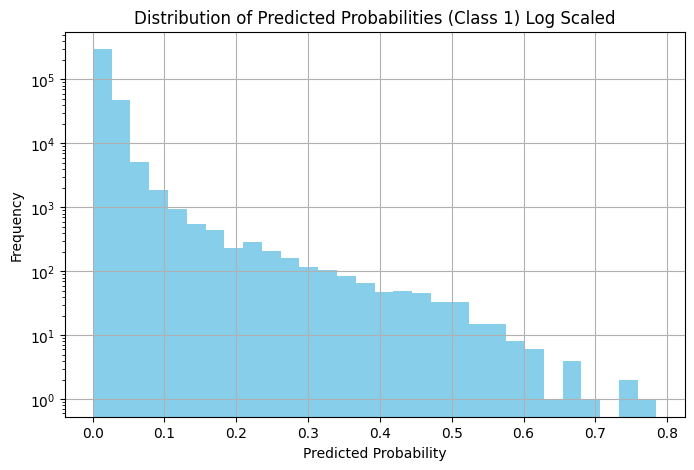

0.78512454 0.020981472


In [152]:
y_probs = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()
print(y_probs.max(),y_probs.mean())

In [5]:
# 2. Define model
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

# 3. Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200,300],          # Number of trees
    "max_depth": [3, 4, 5, 6],                   # Maximum tree depth
    "learning_rate": [0.01, 0.05, 0.1,], 
    "scale_pos_weight":[1.5],
    "objective": ["binary:logistic"],               # Binary classification
    "eval_metric": ["logloss", "aucpr"],
    'lambda': [3,5],
    'alpha': [1,2],
    'gamma': [1]
}

# 4. Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # Change to 'roc_auc' for AUC
    verbose=1,
    n_jobs=-1  # Use all processors
)

# 5. Fit
grid_search.fit(X_train, y_train)

# 6. Best model and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# 7. Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Metrics
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print("Confusion Matrix:\n", cm)
print(f"False Positive Rate: {false_positive_rate:.2f}")
print(f"False Negative Rate: {false_negative_rate:.2f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits


c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:32:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'eval_metric': 'logloss', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300, 'objective': 'binary:logistic', 'scale_pos_weight': 1.5}
Best CV Score: 0.009453125791708468
Test Accuracy: 0.9850387933373121
Confusion Matrix:
 [[72615    26]
 [ 1077     6]]
False Positive Rate: 0.00
False Negative Rate: 0.99


0.853886 0.017272715


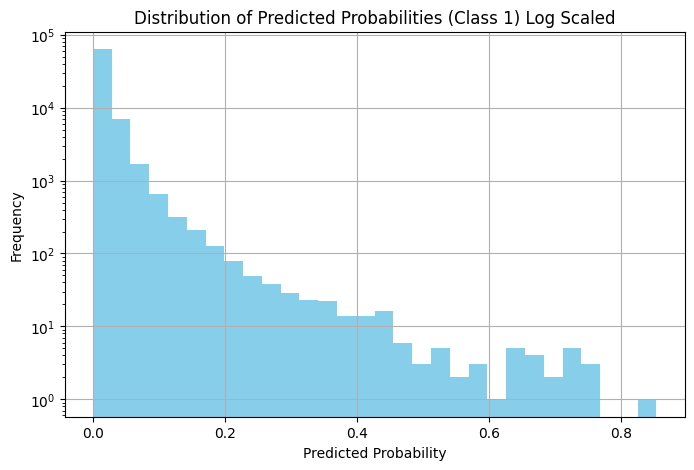

In [6]:
y_probs = best_model.predict_proba(X_test)[:, 1]
print(y_probs.max(),y_probs.mean())
plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()

# Making the final model (XGBoost Classifier)

0.9724478 0.021077702
0.9724478 0.021077702


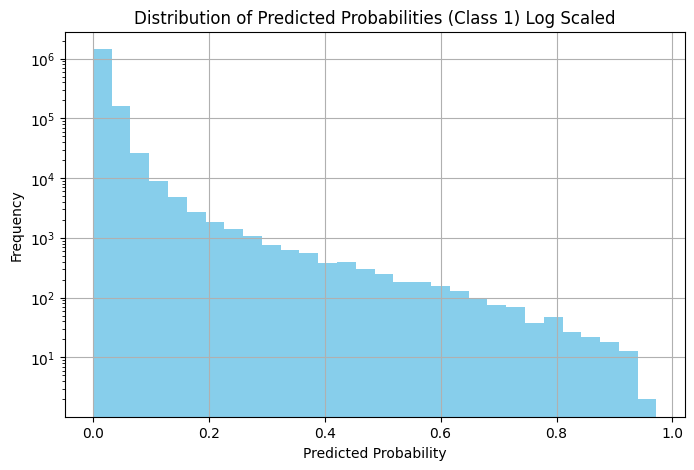

In [190]:
#scale_pos_weight = np.sqrt(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
import json
best_parameters =  {'eval_metric': 'logloss', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300, 'objective': 'binary:logistic', 'scale_pos_weight': 1.5}
#final_xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr',objective='binary:logistic',scale_pos_weight=scale_pos_weight,learning_rate= 0.05,max_depth= 3, n_estimators= 50)
final_xgb_model = xgb.XGBClassifier(use_label_encoder = False, **best_parameters)
final_xgb_model.fit(X,y)
print(final_xgb_model.predict_proba(X)[:,1].max(),final_xgb_model.predict_proba(X)[:,1].mean())
final_xgb_model.save_model('final_xgb_modelV3.json')
y_probs = final_xgb_model.predict_proba(X)[:, 1]
print(y_probs.max(),y_probs.mean())
plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()

with open('predDist.json', 'w') as f:
    json.dump(y_probs.tolist(), f)


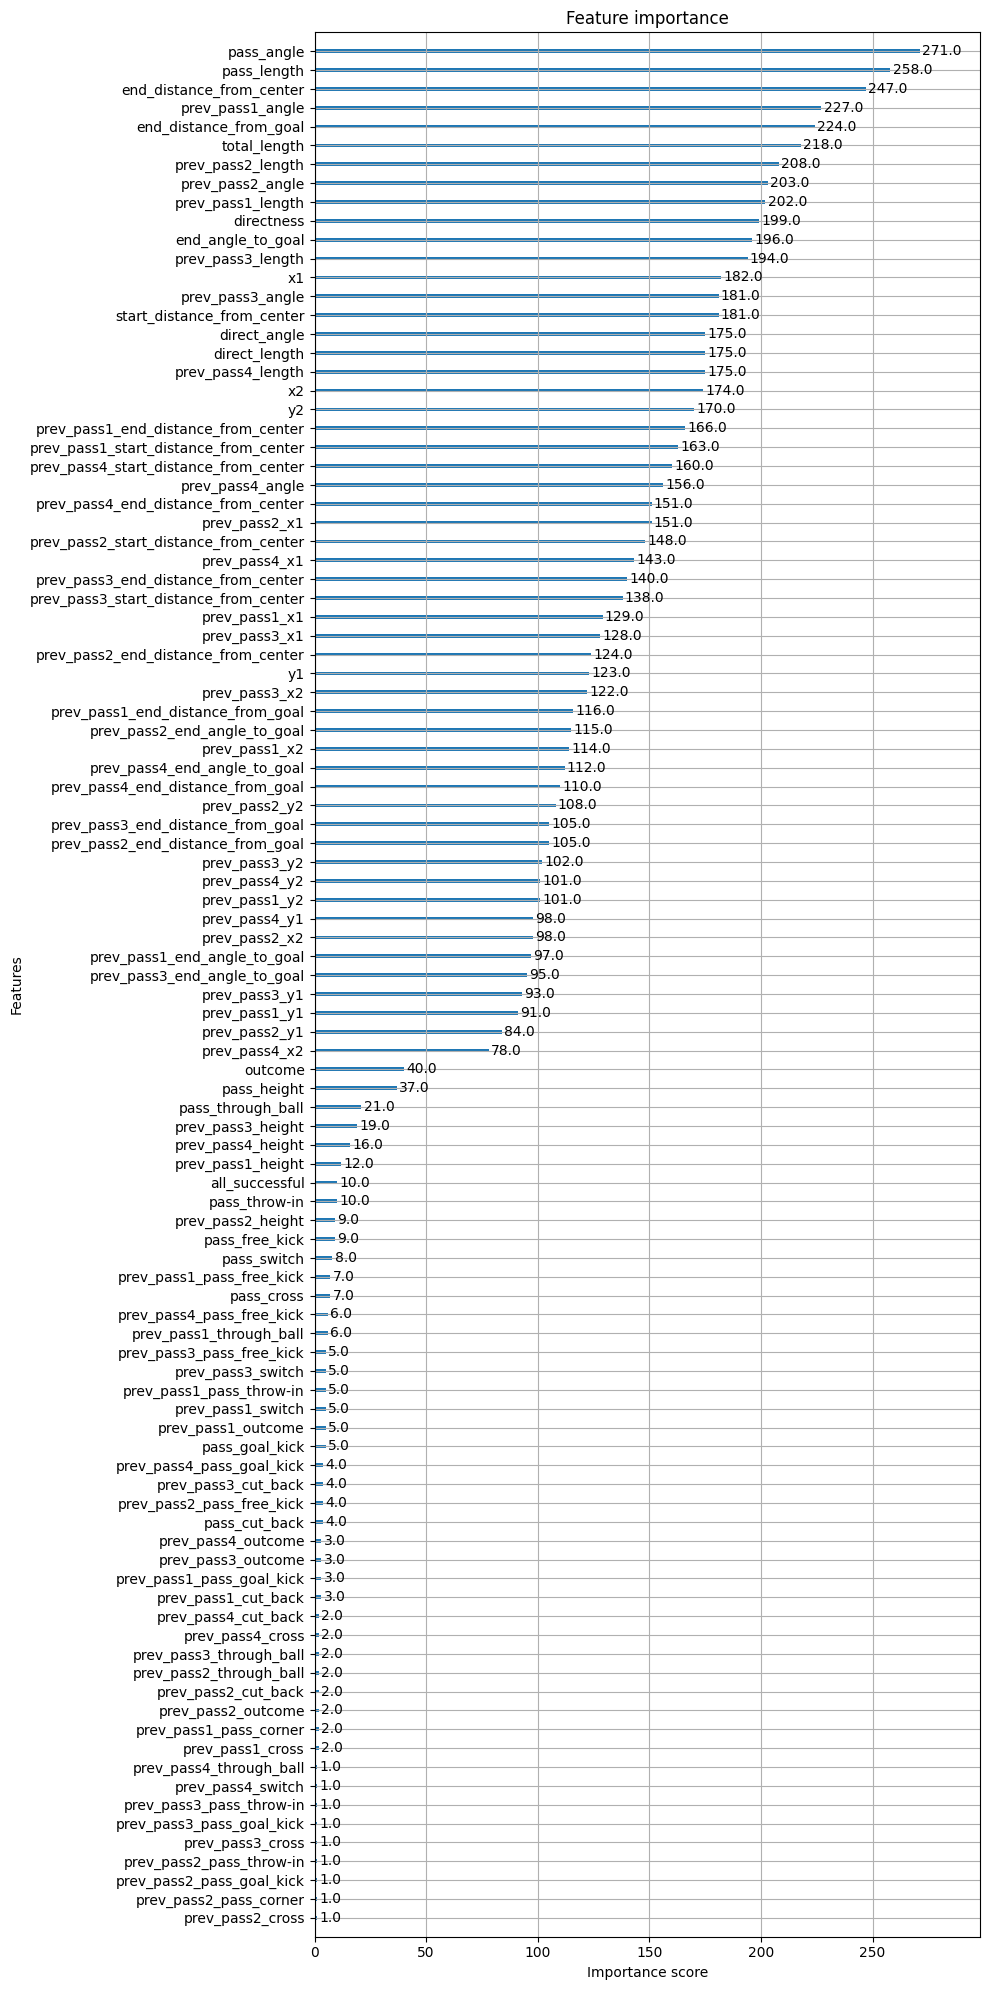

In [172]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(final_xgb_model,ax=ax)
plt.tight_layout()
plt.show()

## Multistage Model

In [173]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
model_df = pd.read_parquet('model_dataframeMSMAll.parquet')

X = model_df.drop(["goal_in_possession","shot_in_possession"],axis=1)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
y1 = model_df["shot_in_possession"]
y2 = model_df["goal_in_possession"]

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2)

In [174]:
import joblib
class MultiStageModel:
    def __init__(self, parameters):
        self.parameters = parameters or {}
        self.model1 = xgb.XGBClassifier(use_label_encoder=False, **self.parameters)
        self.model2 = xgb.XGBClassifier(use_label_encoder=False, **self.parameters)

    def fit(self, X, y1, y2):
        self.model1.fit(X, y1)
        X_stage2 = X[y1 == 1]
        self.model2.fit(X_stage2, y2[y1 == 1])

    def predict_proba(self, X):
        p1 = self.model1.predict_proba(X)[:, 1]
        p2 = self.model2.predict_proba(X)[:, 1]
        return p1 * p2
    def save(self, path_prefix):
        joblib.dump(self.model1, f"{path_prefix}_model1.pkl")
        joblib.dump(self.model2, f"{path_prefix}_model2.pkl")
        joblib.dump(self.parameters, f"{path_prefix}_params.pkl")

    @classmethod
    def load(cls, path_prefix):
        parameters = joblib.load(f"{path_prefix}_params.pkl")
        instance = cls(parameters)
        instance.model1 = joblib.load(f"{path_prefix}_model1.pkl")
        instance.model2 = joblib.load(f"{path_prefix}_model2.pkl")
        return instance

0.88934344 0.027187739


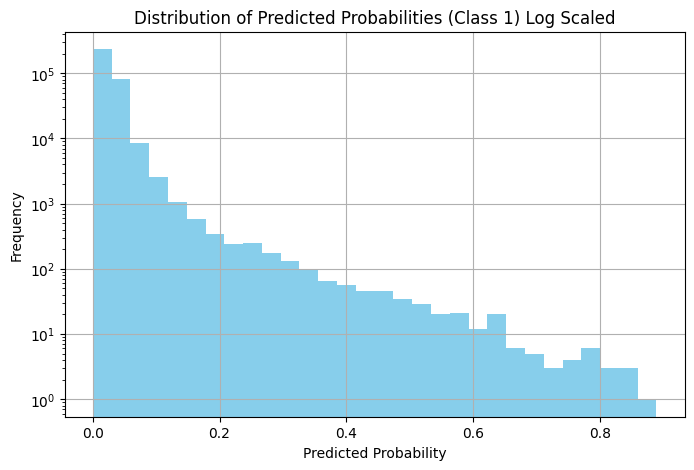

In [175]:
best_parameters =  {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'objective': 'binary:logistic', 'scale_pos_weight': 1.5}
msm = MultiStageModel(best_parameters)
msm.fit(X_train, y1_train, y2_train)
y_probs = msm.predict_proba(X_test)
print(y_probs.max(),y_probs.mean())
plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()


In [176]:
msm.fit(X,y1,y2)
msm.save('msm_model')


0.8609619 0.027224885


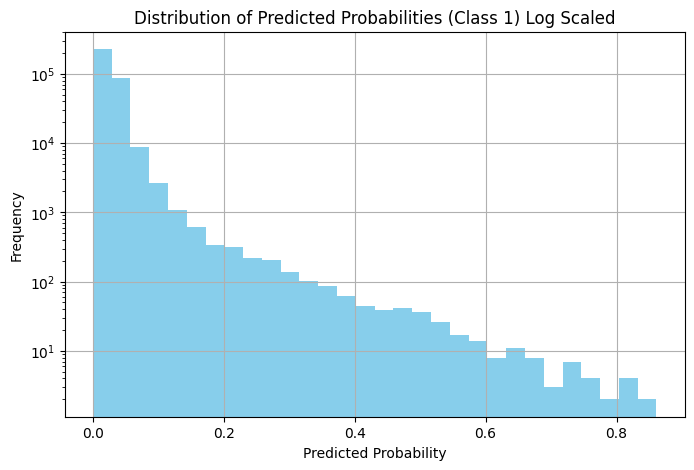

In [177]:
y_probs = msm.predict_proba(X_test)
print(y_probs.max(),y_probs.mean())
plt.figure(figsize=(8, 5))
plt.hist(y_probs, bins=30, color='skyblue')
plt.title("Distribution of Predicted Probabilities (Class 1) Log Scaled")
plt.xlabel("Predicted Probability") 
plt.ylabel("Frequency")
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
plt.show()


# Testing Preprocessing classes

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

class PassPreprocessor:
    def __init__(self):
        self.events = {
            "Pass": {
                "outcome": {
                    'col': 'pass_outcome',
                    False: {'Out', 'Incomplete', 'Unknown', 'Injury Clearance', 'Pass Offside'}
                },
                'end_loc': 'pass_end_location'
            },
            "Carry": {'end_loc': 'carry_end_location'},
            "Ball Recovery": {
                "outcome": {'col': 'ball_recovery_recovery_failure', False: {True}}
            },
            "Duel": {
                "outcome": {'col': 'duel_outcome', False: {'Lost', 'Lost In Play', 'Lost Out', np.nan}}
            },
            "Clearance": {},
            "Miscontrol": {},
            "Dribble": {
                "outcome": {'col': 'dribble_outcome', False: {'Incomplete'}}
            },
            "Shot": {
                "outcome": {
                    'col': 'shot_outcome',
                    False: {'Off T', 'Post', 'Saved', 'Wayward', 'Blocked', 'Saved Off T',
                           'Saved To Post', 'Saved Off Target', 'Off Target'}
                }
            },
            "Interception": {
                "outcome": {'col': 'interception_outcome', False: {'Lost', 'Lost In Play', 'Lost Out'}}
            },
            "Foul Committed": {}
        }
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, events):
        # Sort events chronologically
        ordered_events = events.sort_values(by=["period", "timestamp"])
        ordered_events = ordered_events[~ordered_events["location"].isna()]

        # Select relevant columns
        event_related_cols = [col for col in ordered_events.columns 
                             if any([event.lower().replace(" ","_") in col.lower() 
                                   for event in self.events.keys()])]
        base_cols = ["type", "possession", "possession_team", "team", 'team_id', "location",
                    "timestamp", "period", "duration", "id", "match_id", "minute", "second",
                    'player', 'player_id', 'under_pressure', 'period', 'position']
        cols = sorted(event_related_cols + base_cols)
        
        ordered_events = ordered_events[ordered_events["type"].isin(self.events.keys())][cols]

        # Create unified outcome column
        ordered_events["outcome"] = ordered_events.apply(self._get_outcome, axis=1)

        # Create unified end location column
        ordered_events["end_loc"] = ordered_events.apply(self._get_end_loc, axis=1)

        # Handle special pass types
        special_pass_types = ['Corner', 'Free Kick', 'Throw-in', "Goal Kick"]
        ordered_events.loc[ordered_events["pass_type"].isin(special_pass_types), "type"] = ordered_events["pass_type"]

        # Get max xG per possession
        shots_max = ordered_events[ordered_events.type == "Shot"].groupby("possession")[["shot_statsbomb_xg"]].max()
        # ordered_events = ordered_events.merge(
        #     shots_max.rename(columns={"shot_statsbomb_xg": "max_xg_in_possession"}),
        #     on="possession",
        #     how="left"
        # )
        #ordered_events["max_xg_in_possession"] = ordered_events["max_xg_in_possession"].fillna(0)

        # Filter for passes and extract coordinates
        df = ordered_events[ordered_events.type == "Pass"]
        df = df[['possession', "type", "outcome", "location", "end_loc", 
                 'pass_angle', 'pass_length']]
        
        for point, coords in [('1', 'location'), ('2', 'end_loc')]:
            df[f'x{point}'] = df[coords].apply(lambda x: x[0])
            df[f'y{point}'] = df[coords].apply(lambda x: x[1])
        df = df.drop(['location', 'end_loc'], axis=1)

        # Calculate distances and angles
        df["start_distance_from_center"] = (df['y1'] - 40).abs()
        df['end_distance_from_center'] = (df['y2'] - 40).abs()
        df['end_distance_from_goal'] = ((120 - df['x2']).pow(2) + (40 - df['y2']).pow(2)).pow(0.5)
        df['end_angle_to_goal'] = np.arctan2(40 - df['y2'], 120 - df['x2'])

        # Create features from previous 5 passes
        features = {
            'angle': 'pass_angle',
            'length': 'pass_length',
            'x1': 'x1',
            'y1': 'y1', 
            'x2': 'x2',
            'y2': 'y2',
            'start_distance_from_center': 'start_distance_from_center',
            'end_distance_from_center': 'end_distance_from_center',
            'end_distance_from_goal': 'end_distance_from_goal',
            'end_angle_to_goal': 'end_angle_to_goal',
            'outcome': 'outcome'
        }

        for i in range(1, 5):
            for feature, col in features.items():
                df[f'prev_pass{i}_{feature}'] = df.groupby('possession')[col].shift(i)

        return df.drop(['possession', 'type'], axis=1)
        
    def _get_outcome(self, row):
        event_dict = self.events.get(row["type"], {})
        if "outcome" in event_dict:
            outcome_col = event_dict["outcome"]["col"]
            return 0 if row.get(outcome_col) in event_dict["outcome"][False] else 1
        return np.nan
        
    def _get_end_loc(self, row):
        event_dict = self.events.get(row["type"], {})
        return row.get(event_dict.get("end_loc")) if "end_loc" in event_dict else np.nan

game = sb.events(match_id=match_id)


# Create pipeline 
pipeline = Pipeline([
    ('game_processor', PassPreprocessor())
])

# Process the game data through the pipeline
processed_game = pipeline.transform(game)

processed_game

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,outcome,pass_angle,pass_length,x1,y1,x2,y2,start_distance_from_center,end_distance_from_center,end_distance_from_goal,...,prev_pass4_length,prev_pass4_x1,prev_pass4_y1,prev_pass4_x2,prev_pass4_y2,prev_pass4_start_distance_from_center,prev_pass4_end_distance_from_center,prev_pass4_end_distance_from_goal,prev_pass4_end_angle_to_goal,prev_pass4_outcome
6,1.0,-2.982596,34.738163,60.0,40.0,25.7,34.5,0.0,5.5,94.460256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.462286,65.695740,30.4,24.1,89.2,53.4,15.9,13.4,33.588689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.340577,30.236732,30.9,26.7,59.4,36.8,13.3,3.2,60.684430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.316825,25.678005,60.7,43.3,85.1,51.3,3.3,11.3,36.683784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1.0,-1.089909,12.971122,35.0,36.5,41.0,25.0,3.5,15.0,80.411442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1.0,0.577192,15.393830,64.6,39.4,77.5,47.8,0.6,7.8,43.209837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1066,1.0,-1.147127,22.378561,76.7,41.4,85.9,21.0,1.4,19.0,39.036009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,1.0,-0.907241,20.944212,89.0,20.8,101.9,4.3,19.2,35.7,40.026241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,1.0,1.387757,50.544340,101.9,4.3,111.1,54.0,35.7,14.0,16.589454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Testing possible inputs from html for pipeline to process and then predict

In [60]:
pass1startloc = [40, 20]
pass1endloc = [30, 60]
pass1outcome = 1  # Successful pass moving up field
pass1type = "Throw-in"
pass1height = "Ground"

pass2startloc = [85, 45] 
pass2endloc = [95, 30]
pass2outcome = 1  # Failed pass - too close to goal line
pass2type = "Pass"
pass2height = "Ground"

pass3startloc = [15, 70]
pass3endloc = [25, 75]
pass3outcome = 1  # Successful short pass forward
pass3type = "Pass"
pass3height = "Ground"

pass4startloc = [60, 10]
pass4endloc = [75, 25]
pass4outcome = 0  # Successful diagonal pass upfield
pass4type = "Pass"
pass4height = "Ground"

pass5startloc = [110, 65]
pass5endloc = [100, 50]
pass5outcome = 1
pass5type = "Cross"
pass5height = "High"

inputs = [
    *pass1startloc, *pass1endloc, pass1outcome, pass1type, pass1height,
    *pass2startloc, *pass2endloc, pass2outcome, pass2type, pass2height,
    *pass3startloc, *pass3endloc, pass3outcome, pass3type, pass3height,
    *pass4startloc, *pass4endloc, pass4outcome, pass4type, pass4height,
    *pass5startloc, *pass5endloc, pass5outcome, pass5type, pass5height,
]
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class websiteInputPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # Initialize array to store features
        features = []
        
        # Process each pass (every 5 elements in input list)
        for i in range(0, 35, 7):
            try:
                start_loc = X[i:i+2]
                end_loc = X[i+2:i+4]
                outcome = X[i+4]
                
                # Calculate pass features
                pass_angle = np.arctan2(end_loc[1] - start_loc[1], end_loc[0] - start_loc[0])
                pass_length = np.sqrt((end_loc[0] - start_loc[0])**2 + (end_loc[1] - start_loc[1])**2)
                
                # Calculate distances and angles
                start_dist_center = np.abs(start_loc[0] - 40)
                end_dist_center = np.abs(end_loc[0] - 40)
                end_dist_goal = np.sqrt((end_loc[0] - 120)**2 + (end_loc[1] - 40)**2)
                end_angle_goal = np.arctan2(end_loc[1] - 40, end_loc[0] - 120)
                pass_type = X[i+5]
                pass_height = 0 if X[i+6] == "Ground" else 1 if X[i+6] == "Low" else 2
                cross = 1 if pass_type == "Cross" else 0
                throw_in = 1 if pass_type == "Throw-in" else 0
                corner = 1 if pass_type == "Corner" else 0
                free_kick = 1 if pass_type == "Free Kick" else 0
                goal_kick = 1 if pass_type == "Goal Kick" else 0
                cut_back = 1 if pass_type == "Cut-back" else 0
                switch = 1 if pass_type == "Switch" else 0
                through_ball = 1 if pass_type == "Through Ball" else 0

                # Add features in order
                features.extend([
                    outcome,
                    pass_angle,
                    pass_length,
                    cross,
                    cut_back,
                    switch,
                    through_ball,
                    pass_height,
                    start_loc[0],
                    start_loc[1],
                    end_loc[0],
                    end_loc[1],
                    start_dist_center,
                    end_dist_center,
                    end_dist_goal,
                    end_angle_goal,
                    throw_in,
                    corner,
                    free_kick,
                    goal_kick
                ])
            except IndexError:
                features.extend([np.nan] * 20)
        num_passes = np.sum(~np.isnan(np.array(features[::20])))
        # Get coordinates for each pass in sequence
        pass4x2 = features[4*20+10]
        pass4y2 = features[4*20+11]
        pass3x2 = features[3*20+10]
        pass3y2 = features[3*20+11]
        pass2x2 = features[2*20+10]
        pass2y2 = features[2*20+11]
        pass1x2 = features[1*20+10]
        pass1y2 = features[1*20+11]
        pass0x2 = features[0*20+10]
        pass0y2 = features[0*20+11]

        pass0x1 = features[0*20+8]
        pass0y1 = features[0*20+9]
        

        # Find last completed pass end coordinates
        last_pass_x2 = pass4x2
        if pd.isna(last_pass_x2):
            last_pass_x2 = pass3x2
            if pd.isna(last_pass_x2):
                last_pass_x2 = pass2x2
                if pd.isna(last_pass_x2):
                    last_pass_x2 = pass1x2
                    if pd.isna(last_pass_x2):
                        last_pass_x2 = pass0x2

        last_pass_y2 = pass4y2  
        if pd.isna(last_pass_y2):
            last_pass_y2 = pass3y2
            if pd.isna(last_pass_y2):
                last_pass_y2 = pass2y2
                if pd.isna(last_pass_y2):
                    last_pass_y2 = pass1y2
                    if pd.isna(last_pass_y2):
                        last_pass_y2 = pass0y2
        direct_length = np.sqrt((last_pass_x2-pass0x1)**2 + (last_pass_y2-pass0y1)**2)
        total_length = np.nansum(np.array(features[2::20]))
        directness = direct_length/total_length if num_passes > 1 else np.nan
        direct_angle = np.arctan2(last_pass_y2 - pass0y1, last_pass_x2 - pass0x1) if num_passes > 1 else np.nan
        all_successful = np.all(np.isnan(np.array(features[::20])) | (np.array(features[::20]) == 1))
        features.extend([num_passes,direct_length,total_length,directness,direct_angle,all_successful])
        return np.array(features).reshape(1, -1)

import xgboost as xgb

model = xgb.XGBClassifier() 
model.load_model("final_xgb_modelV3.json")  

from sklearn.pipeline import make_pipeline

websitePipeline = make_pipeline(
    websiteInputPreprocessor(),
    model
)
prediction = websitePipeline.predict_proba(inputs)[0,1]
print(prediction)
print(inputs)
websiteInputPreprocessor().transform(inputs)

0.03640146
[40, 20, 30, 60, 1, 'Throw-in', 'Ground', 85, 45, 95, 30, 1, 'Pass', 'Ground', 15, 70, 25, 75, 1, 'Pass', 'Ground', 60, 10, 75, 25, 0, 'Pass', 'Ground', 110, 65, 100, 50, 1, 'Cross', 'High']


array([[  1.        ,   1.81577499,  41.23105626,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         40.        ,  20.        ,  30.        ,  60.        ,
          0.        ,  10.        ,  92.19544457,   2.92292371,
          1.        ,   0.        ,   0.        ,   0.        ,
          1.        ,  -0.98279372,  18.02775638,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         85.        ,  45.        ,  95.        ,  30.        ,
         45.        ,  55.        ,  26.92582404,  -2.76108628,
          0.        ,   0.        ,   0.        ,   0.        ,
          1.        ,   0.46364761,  11.18033989,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         15.        ,  70.        ,  25.        ,  75.        ,
         25.        ,  15.        , 101.24228366,   2.78860227,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.78539816,  21.

# Looking at now specific moments in EUFA Euros

In [191]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import xgboost as xgb
matches = sb.matches(55, 282)
matches.head()
#model = msm
model = xgb.XGBClassifier() 
model.load_model("final_xgb_modelV3.json")  

In [204]:
matches[["match_id","competition_stage"]].set_index("match_id").to_dict()["competition_stage"]

{3942819: 'Semi-finals',
 3943043: 'Final',
 3942752: 'Semi-finals',
 3942382: 'Quarter-finals',
 3942349: 'Quarter-finals',
 3930180: 'Group Stage',
 3930171: 'Group Stage',
 3942227: 'Quarter-finals',
 3942226: 'Quarter-finals',
 3938645: 'Group Stage',
 3930184: 'Group Stage',
 3941022: 'Round of 16',
 3941021: 'Round of 16',
 3941020: 'Round of 16',
 3941019: 'Round of 16',
 3941018: 'Round of 16',
 3941017: 'Round of 16',
 3930182: 'Group Stage',
 3930179: 'Group Stage',
 3940983: 'Round of 16',
 3940878: 'Round of 16',
 3930177: 'Group Stage',
 3930173: 'Group Stage',
 3930172: 'Group Stage',
 3930167: 'Group Stage',
 3930168: 'Group Stage',
 3930165: 'Group Stage',
 3930164: 'Group Stage',
 3930161: 'Group Stage',
 3938637: 'Group Stage',
 3938640: 'Group Stage',
 3938642: 'Group Stage',
 3938639: 'Group Stage',
 3938641: 'Group Stage',
 3938644: 'Group Stage',
 3938643: 'Group Stage',
 3938638: 'Group Stage',
 3930183: 'Group Stage',
 3930181: 'Group Stage',
 3930178: 'Group St

# Finding the goal of the tournament (Lamine Yamal Quarterfinal)

In [181]:
match = matches[(matches.competition_stage=="Semi-finals")&(matches.home_team == "Spain")]
home_team =match.home_team.iloc[0]
away_team = match.away_team.iloc[0]
match_id = matches[(matches.competition_stage=="Semi-finals")&(matches.home_team == "Spain")].match_id.iloc[0]
events = sb.events(match_id)
processed_events = preprocessing(events)
possesion_num = processed_events[(processed_events.type=="Shot") & (processed_events.outcome==True)&(processed_events.player.str.contains("Lamine Yamal"))].possession.iloc[0]
plot_possession(processed_events,home_team,away_team,possesion_num)


AttributeError: 'DataFrame' object has no attribute 'type'

In [277]:
possession_events = processed_events[processed_events.possession==possesion_num]

# Filter for passes and get the last 5 before the shot
five_passes_before_shot = possession_events[
    (possession_events.type.isin(["Goal Kick","Pass"]))&
    (possession_events.index < possession_events[possession_events.type=="Shot"].index[0])
].head(5)
passes_before_shot = five_passes_before_shot.reset_index().sort_values("index",ascending=False)
input =processed_to_model(passes_before_shot).iloc[-1]
input
print("Probability of scoring given the first 5 passes of possession: ",model.predict_proba([input])[0,1])

Probability of scoring given the first 5 passes of possession:  0.011072818


C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\1405349910.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_cross"] = df["pass_cross"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\1405349910.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_cut_back"] = df["pass_cut_back"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\1405349910.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer

In [182]:
# Get all events in the possession
possession_events = processed_events[processed_events.possession==possesion_num]

# Filter for passes and get the last 5 before the shot
passes_before_shot = possession_events[
    (possession_events.type=="Pass") & 
    (possession_events.index < possession_events[possession_events.type=="Shot"].index[0])
].tail(5)

passes_before_shot = passes_before_shot.reset_index().sort_values("index",ascending=False)
input =processed_to_model(passes_before_shot).iloc[-1]
print("Probability of scoring given the 5 passes before: ",model.predict_proba([input])[0,1])

AttributeError: 'DataFrame' object has no attribute 'possession'

In [140]:
passes_before_shot[["location","end_loc"]]

,location,end_loc
4,"[85.3, 34.5]","[91.5, 43.6]"
3,"[54.5, 49.2]","[80.0, 40.8]"
2,"[45.3, 35.6]","[51.5, 48.9]"
1,"[56.2, 6.6]","[46.7, 24.7]"
0,"[75.4, 4.4]","[60.7, 6.1]"


In [127]:
def create_array_from_input(input):
    input = input.to_numpy()
    passes = []
    for i in range(0,len(input),20):
        pass_idx = i//20
        passoutcome = input[0+i]
        passStart = input[i+8:i+10].tolist()
        passEnd = input[i+10:i+12].tolist()
        passCross = input[i+3]
        passCutBack = input[i+4]
        passSwitch = input[i+5]
        passThrough = input[i+6]
        passHeight = input[i+7]

        passCorner = input[i+16]
        passFreeKick = input[i+17]
        passGoalKick = input[i+18]
        passThrowIn = input[i+19]
        if passCorner:
            passType = "Corner"
        elif passFreeKick:
            passType = "Free Kick"
        elif passGoalKick:
            passType = "Goal Kick"
        elif passThrowIn:
            passType = "Throw-in"
        elif passCross:
            passType = "Cross"
        elif passCutBack:
            passType = "Cut-back"
        elif passSwitch:
            passType = "Switch"
        elif passThrough:
            passType = "Through Ball"
        else:
            passType = "Pass"
        passes.append({
            "outcome": passoutcome,
            "start": passStart,
            "end": passEnd,
            "type": passType,
            "height": passHeight
        })
    return passes
result = create_array_from_input(input)
with open("lamine_chance_last_5.json", "w") as f:
    json.dump(result, f, indent=2)





In [154]:
matches.competition_stage.unique()

array(['Semi-finals', 'Final', 'Quarter-finals', 'Group Stage',
       'Round of 16'], dtype=object)

c:\Users\zcoch\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


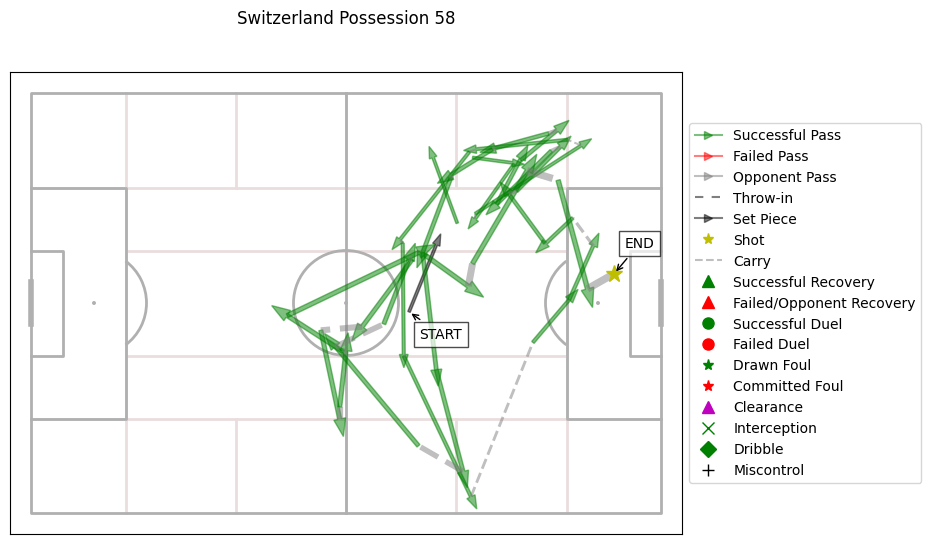

In [157]:
match = matches[(matches.competition_stage=="Round of 16")&(matches.home_team == "Switzerland")]
match
home_team =match.home_team.iloc[0]
away_team = match.away_team.iloc[0]
match_id = matches[(matches.competition_stage=="Round of 16")&(matches.home_team == "Switzerland")].match_id.iloc[0]
events = sb.events(match_id)
processed_events = preprocessing(events)
possesion_num = processed_events[(processed_events.type=="Shot") & (processed_events.outcome==True)&(processed_events.player.str.contains("Freuler"))].possession.iloc[0]
plot_possession(processed_events,home_team,away_team,possesion_num)

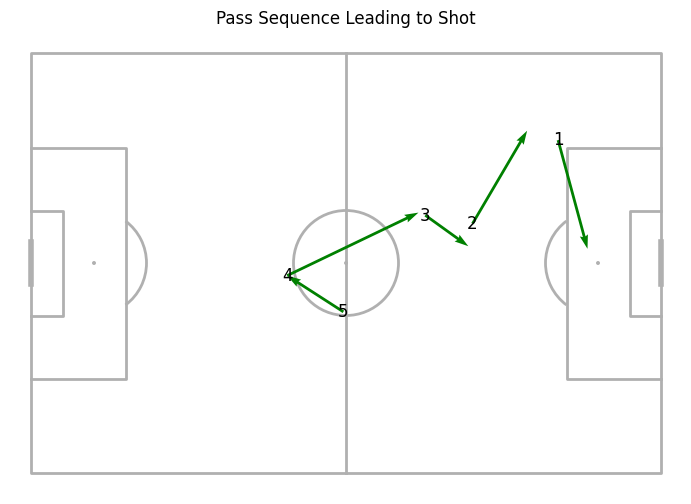

Probability of scoring given the first 5 passes of possession:  0.10865256


C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_switch"] = df["pass_switch"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pass_through_ball"] = df["pass_through_ball"].fillna(0).astype(int)
C:\Users\zcoch\AppData\Local\Temp\ipykernel_33244\532672612.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [165]:
possession_events = processed_events[processed_events.possession==possesion_num]

# Filter for passes and get the last 5 before the shot
five_passes_before_shot = possession_events[
    (possession_events.type.isin(["Goal Kick","Pass"]))&
    (possession_events.index < possession_events[possession_events.type=="Shot"].index[0])
].tail(5)
passes_before_shot = five_passes_before_shot.reset_index().sort_values("index",ascending=False)
# Create pitch visualization
pitch = Pitch()
fig, ax = plt.subplots(figsize=(10, 6))
pitch.draw(ax=ax)

# Plot each pass
for idx, row in passes_before_shot.iterrows():
    # Get start and end locations
    start_loc = row['location']
    end_loc = row['end_loc']
    
    # Plot arrow for pass
    if start_loc is not None and end_loc is not None:
        # Use green for completed passes, red for failed passes
        color = 'green' if row['outcome'] == 1.0 else 'red'
        pitch.arrows(start_loc[0], start_loc[1], 
                    end_loc[0], end_loc[1],
                    color=color, width=2, ax=ax)
        
        # Add pass number annotation
        ax.text(start_loc[0], start_loc[1], str(5-idx), 
                fontsize=12, ha='center', va='center',
                color='black', zorder=2)

plt.title('Pass Sequence Leading to Shot')
plt.show()
input =processed_to_model(passes_before_shot).iloc[-1]
input
print("Probability of scoring given the first 5 passes of possession: ",model.predict_proba([input])[0,1])

In [166]:
result = create_array_from_input(input)
with open("freuler_chance_last_5.json", "w") as f:
    json.dump(result, f, indent=2)

# Looking at all pass sequences in all euro games

In [208]:
import pandas as pd
dfs = []
match_dict = matches[["match_id","competition_stage"]].set_index("match_id").to_dict()["competition_stage"]
print(match_dict.keys())
for match_id in match_dict.keys():
    print(match_id)
    df = sb.events(match_id=match_id)
    df_with_team, df = preprocessing_for_model_input(df)
    preds = model.predict_proba(df)[:,1]
    df["sequence_pred"] = preds
    df["team"] = df_with_team["team"]
    df["possession"] = df_with_team["possession"]
    df["competition_stage"] = match_dict[match_id]
    df['match_id'] = match_id
    dfs.append(df)
all_sequences = pd.concat(dfs)







dict_keys([3942819, 3943043, 3942752, 3942382, 3942349, 3930180, 3930171, 3942227, 3942226, 3938645, 3930184, 3941022, 3941021, 3941020, 3941019, 3941018, 3941017, 3930182, 3930179, 3940983, 3940878, 3930177, 3930173, 3930172, 3930167, 3930168, 3930165, 3930164, 3930161, 3938637, 3938640, 3938642, 3938639, 3938641, 3938644, 3938643, 3938638, 3930183, 3930181, 3930178, 3930176, 3930175, 3930174, 3930170, 3930169, 3930166, 3930163, 3930162, 3930160, 3930159, 3930158])
3942819
3943043
3942752
3942382
3942349
3930180
3930171
3942227
3942226
3938645
3930184
3941022
3941021
3941020
3941019
3941018
3941017
3930182
3930179
3940983
3940878
3930177
3930173
3930172
3930167
3930168
3930165
3930164
3930161
3938637
3938640
3938642
3938639
3938641
3938644
3938643
3938638
3930183
3930181
3930178
3930176
3930175
3930174
3930170
3930169
3930166
3930163
3930162
3930160
3930159
3930158


In [193]:
sums = all_sequences.groupby(["team","possession"])[["sequence_pred"]].max().reset_index().groupby("team")["sequence_pred"].sum().sort_values(ascending=False)
#sums = all_sequences.groupby("team")["sequence_pred"].sum().sort_values(ascending=False)
sums

team
Spain             18.770912
Portugal          17.127899
Germany           16.410322
France            16.030838
England           14.966426
Netherlands       14.027772
Switzerland       12.554725
Austria           12.443054
Denmark           12.155917
Turkey            11.839868
Ukraine           10.502025
Croatia           10.355347
Belgium           10.276468
Italy             10.108112
Slovakia           9.894556
Slovenia           9.227235
Serbia             8.398280
Czech Republic     8.206647
Romania            7.861887
Georgia            7.662694
Hungary            7.197342
Poland             6.987619
Albania            6.175806
Scotland           6.134998
Name: sequence_pred, dtype: float32

In [186]:
mp = pd.concat([matches.home_team, matches.away_team]).value_counts()
(sums/mp).sort_values(ascending=False)

Ukraine           3.500675
Croatia           3.451782
Portugal          3.425580
Germany           3.282064
Austria           3.110764
Denmark           3.038979
Serbia            2.799427
Czech Republic    2.735549
Spain             2.681559
France            2.671806
Belgium           2.569117
Italy             2.527028
Switzerland       2.510945
Slovakia          2.473639
Hungary           2.399114
Turkey            2.367974
Netherlands       2.337962
Poland            2.329206
Slovenia          2.306809
England           2.138061
Albania           2.058602
Scotland          2.044999
Romania           1.965472
Georgia           1.915674
dtype: float64

In [187]:
all_sequences.groupby(["team","possession"])[["sequence_pred"]].max().reset_index().groupby("team")["sequence_pred"].mean().sort_values(ascending=False)

team
Spain             0.100919
France            0.096571
Netherlands       0.089922
Portugal          0.088746
Germany           0.086370
England           0.086014
Denmark           0.079450
Turkey            0.074465
Switzerland       0.074288
Austria           0.073628
Croatia           0.072925
Ukraine           0.071932
Italy             0.071184
Belgium           0.061536
Serbia            0.058321
Slovakia          0.054666
Slovenia          0.053337
Czech Republic    0.052272
Hungary           0.051045
Romania           0.046797
Georgia           0.046724
Poland            0.046276
Albania           0.040899
Scotland          0.039838
Name: sequence_pred, dtype: float32

In [209]:
all_sequences.to_csv("europe_sequences_preds.csv",index=False)

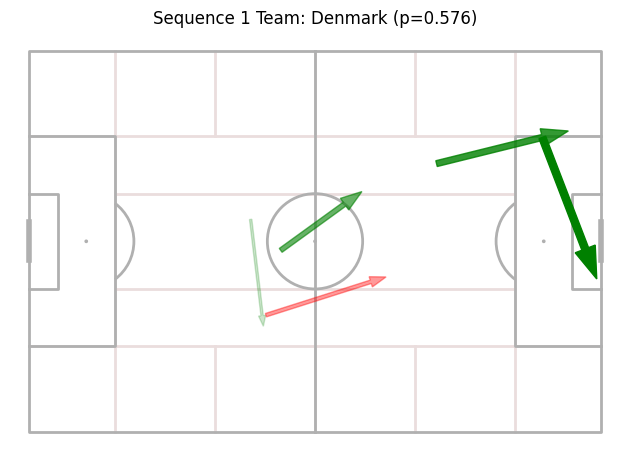

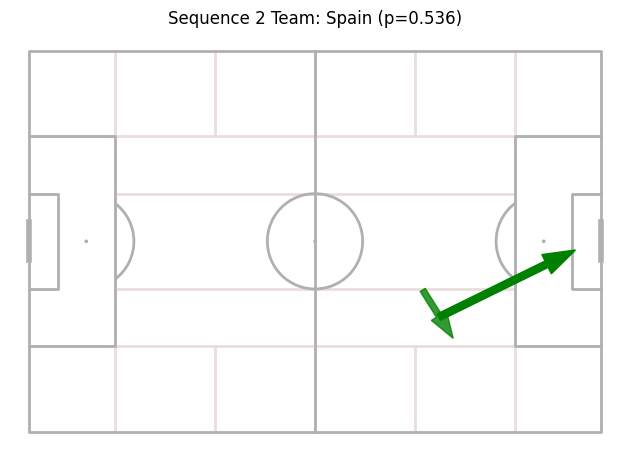

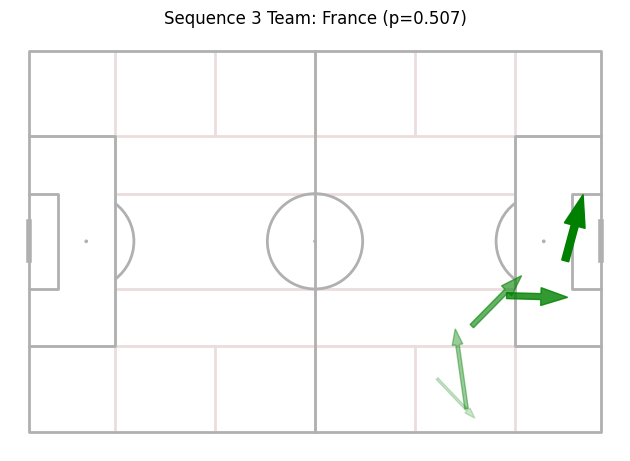

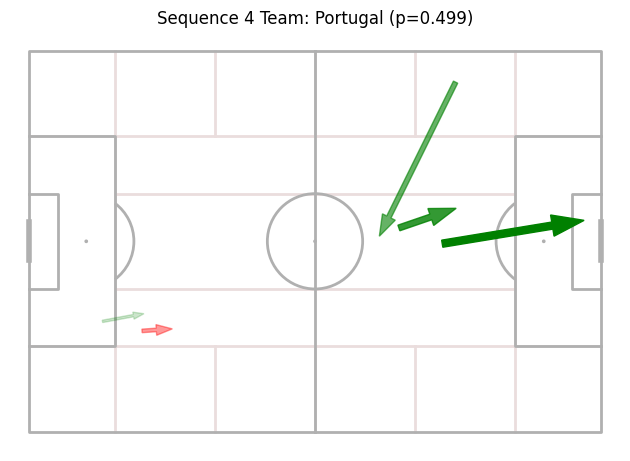

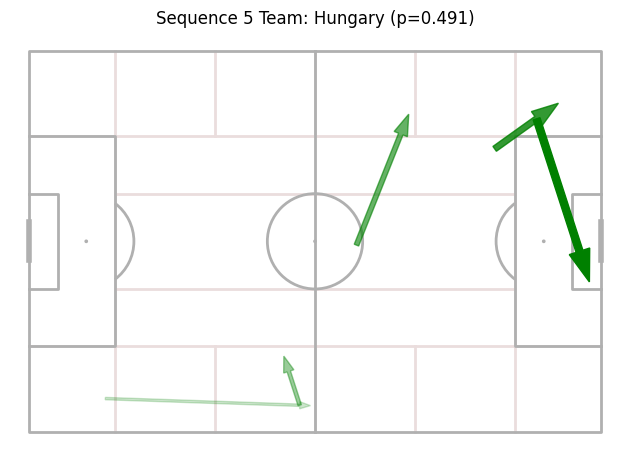

In [118]:
# Get coordinates of top 5 highest probability sequences
top_5_coords = all_sequences.sort_values("sequence_pred", ascending=False).head(5)

# Create pitch visualization
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define colors based on pass outcome
success_color = 'green'
fail_color = 'red'

# Create subplots for each sequence

for idx, (_, coords) in enumerate(top_5_coords.iterrows()):
    pitch = Pitch(positional=True)
    fig, ax = pitch.draw()
    
    # Plot each pass in sequence with different alphas and line thicknesses
    alphas = [1.0, 0.8, 0.6, 0.4, 0.2]
    linewidths = np.array([3, 2.5, 2, 1.5, 1])/2

    # Plot pass 4 (earliest)
    if not pd.isna(coords.prev_pass4_x1):
        color = success_color if coords.prev_pass4_outcome == 1.0 else fail_color
        dx = coords.prev_pass4_x2 - coords.prev_pass4_x1
        dy = coords.prev_pass4_y2 - coords.prev_pass4_y1
        ax.arrow(coords.prev_pass4_x1, coords.prev_pass4_y1, dx, dy,
                color=color, alpha=alphas[4], width=linewidths[4])

    # Plot pass 3
    if not pd.isna(coords.prev_pass3_x1):
        color = success_color if coords.prev_pass3_outcome == 1.0 else fail_color
        dx = coords.prev_pass3_x2 - coords.prev_pass3_x1
        dy = coords.prev_pass3_y2 - coords.prev_pass3_y1
        ax.arrow(coords.prev_pass3_x1, coords.prev_pass3_y1, dx, dy,
                color=color, alpha=alphas[3], width=linewidths[3])

    # Plot pass 2  
    if not pd.isna(coords.prev_pass2_x1):
        color = success_color if coords.prev_pass2_outcome == 1.0 else fail_color
        dx = coords.prev_pass2_x2 - coords.prev_pass2_x1
        dy = coords.prev_pass2_y2 - coords.prev_pass2_y1
        ax.arrow(coords.prev_pass2_x1, coords.prev_pass2_y1, dx, dy,
                color=color, alpha=alphas[2], width=linewidths[2])

    # Plot pass 1
    if not pd.isna(coords.prev_pass1_x1):
        color = success_color if coords.prev_pass1_outcome == 1.0 else fail_color
        dx = coords.prev_pass1_x2 - coords.prev_pass1_x1
        dy = coords.prev_pass1_y2 - coords.prev_pass1_y1
        ax.arrow(coords.prev_pass1_x1, coords.prev_pass1_y1, dx, dy,
                color=color, alpha=alphas[1], width=linewidths[1])

    # Plot final pass
    color = success_color if coords.outcome == 1.0 else fail_color
    dx = coords.x2 - coords.x1
    dy = coords.y2 - coords.y1
    ax.arrow(coords.x1, coords.y1, dx, dy,
            color=color, alpha=alphas[0], width=linewidths[0])
    
    ax.set_title(f'Sequence {idx+1} Team: {coords.team} (p={round(coords.sequence_pred,3)})')
    plt.show()
    